In [1]:
import sys
sys.path.append('..')
from mtDNAsim import *

/home/wangkun/mtDNA_simulation/notebook/../mtDNAsim/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
plt.rcParams['font.size'] = 12

In [4]:
# num_elements = 5
# system = Gillespie(
#     num_elements,
#     inits=[1, 0, 0, 0, 0],
#     max_cell_num=8000
# )

# p0 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 17))))
# p1 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 17))))
# p2 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 17))))
# p3 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
# p4 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 19))))
# d0 = lambda t: 1 - p0(t)
# d1 = lambda t: 1 - p1(t)
# d2 = lambda t: 1 - p2(t)
# d3 = lambda t: 1 - p3(t)

# system.add_reaction(p0, [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], index=0) # 0 self renew
# system.add_reaction(p1, [0, 1, 0, 0, 0], [0, 2, 0, 0, 0], index=1) # 1 self renew
# system.add_reaction(p2, [0, 0, 1, 0, 0], [0, 0, 2, 0, 0], index=2) # 2 self renew
# system.add_reaction(p3, [0, 0, 0, 1, 0], [0, 0, 0, 2, 0], index=3) # 3 self renew
# system.add_reaction(p4, [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], index=4) # 4 self renew
# system.add_reaction(d0, [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], index=5) # 0 -> 1 differentiation
# system.add_reaction(d1, [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], index=6) # 1 -> 2 differentiation
# system.add_reaction(d2, [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], index=7) # 2 -> 3 differentiation
# system.add_reaction(d3, [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], index=8) # 3 -> 4 differentiation

# system.evolute(20000000)

In [5]:
# data_path = "../results/"
# tree_file_name = "tree_origin_linear.csv0"
# cell_num_file_name = "cell_num_linear.csv0"

# curr_cells = []
# t = np.array(system.generation_time)
# cell_num_traj = np.array(system.n)

# for i in system.curr_cells.values():
#     curr_cells += i
# while tree_file_name in os.listdir(data_path):
#     tree_file_name = tree_file_name[:-1] + str(int(tree_file_name[-1]) + 1)
#     cell_num_file_name = cell_num_file_name[:-1] + str(int(cell_num_file_name[-1]) + 1)

# np.savetxt(
#     data_path + cell_num_file_name,
#     np.hstack((t.reshape(-1, 1), cell_num_traj)),
#     fmt="%.5f",
# )

# sim_utils.wirte_lineage_info(
#     data_path + tree_file_name, system.anc_cells, curr_cells, system.t[-1]
# )


In [6]:
# reconstruct('./results/tree_origin_linear.csv0', output='./results/tree_origin_linear.nwk', num=1000, is_balance=True)

In [7]:
tree_file = '../results/tree_origin_linear.nwk'
phylo_tree, branch_colors = loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = get_annotation('../results/tree_origin_linear.csv0')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [8]:
sd = scData(
    phylo_tree=phylo_tree,
    cell_states=cell_states.to_numpy().T[0].astype('int'),
    cell_generation=cell_generation.T[0].astype('int'),
    cell_names=sampled_cells
)

In [9]:
ge, base_expr = sim_base_expr(sd.phylo_tree,
                                 cell_states,
                                 Ngene=2000,
                                 r_variant_gene=0.4,
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0,
                                 mu0_scale=1,
                                 drift_loc=0,
                                 drift_scale=0.3,
                                )

In [10]:
sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

In [11]:
sd.dimensionality_reduction()

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


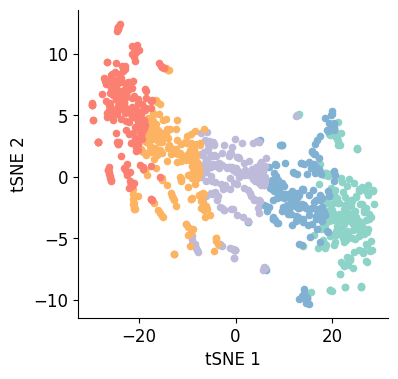

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i], s=20)
ax.set_xlabel('tSNE 1', )
ax.set_ylabel('tSNE 2', )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [13]:
seqs = DNAmutation(sd.phylo_tree, mut_rate=0.1)

In [14]:
mt_muts, mutid = mtmutation(sd.phylo_tree, mut_rate=8e-3)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/6523 [00:00<?, ?it/s]

In [15]:
original_mutations = set()
for i in mt_muts['<0_0>']:
    original_mutations = original_mutations.union(i)

In [16]:
mf = mut_freq(mt_muts, mutid, sel_cells=[i.name for i in sd.phylo_tree.get_terminals()])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
plt.rcParams['font.size'] = 8

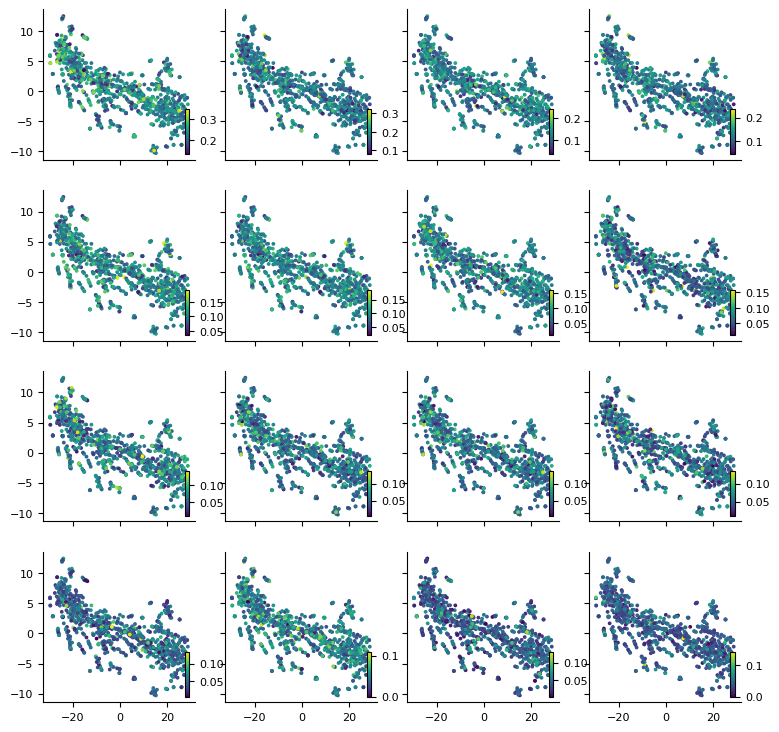

In [18]:
# show_mtmuts = np.random.choice(list(original_mutations), 16, replace=False)
show_mtmuts = mf.sum().sort_values(ascending=False).index[:16]
fig, ax = plt.subplots(4, 4, figsize=(9, 9), sharex=True, sharey=True)
for ind, i in enumerate(show_mtmuts):
    scatter = ax[ind//4][ind%4].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=mf.loc[sd.Xdr.index][i], s=3)
    # ax[i//4][i%4].set_xlabel('tSNE 1', )
    # ax[i//4][i%4].set_ylabel('tSNE 2', )
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)
    cbaxes = inset_axes(ax[ind//4][ind%4], width="3%", height="30%", loc='lower right') 
    plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# plt.tight_layout()

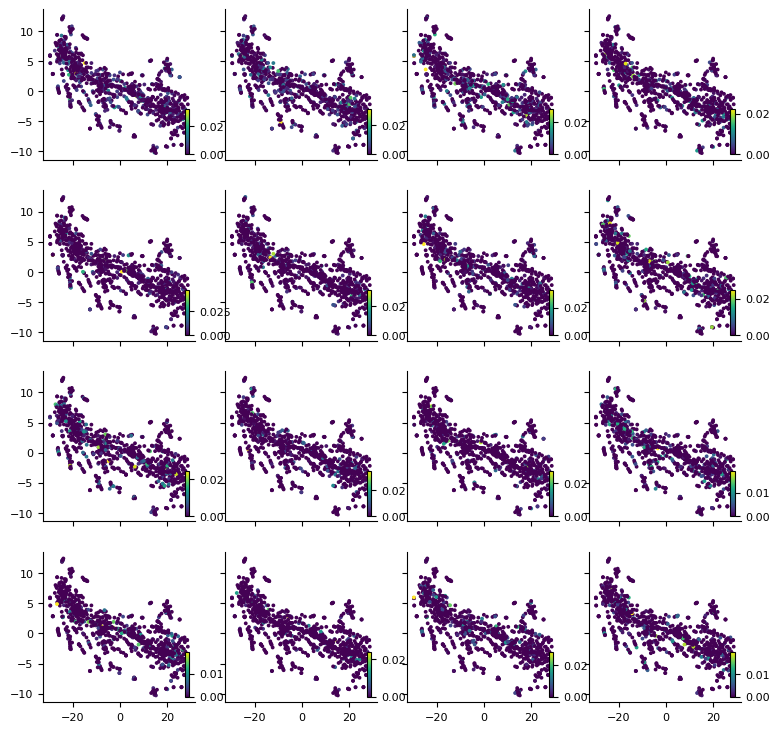

In [19]:
show_mtmuts = mf[list(set(mf.columns)-original_mutations)].sum().sort_values(ascending=False).index[:16]
fig, ax = plt.subplots(4, 4, figsize=(9, 9), sharex=True, sharey=True)
for ind, i in enumerate(show_mtmuts):
    scatter = ax[ind//4][ind%4].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=mf.loc[sd.Xdr.index][i], s=3)
    # ax[i//4][i%4].set_xlabel('tSNE 1', )
    # ax[i//4][i%4].set_ylabel('tSNE 2', )
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)
    cbaxes = inset_axes(ax[ind//4][ind%4], width="3%", height="30%", loc='lower right') 
    plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# plt.tight_layout()